### Google Speech Detection Audio Classication

4. Speech Commands Dataset (Google)
🎯 Goal: Keyword spotting (e.g., “yes”, “no”, “stop”, “go”)

🧾 105,000+ short utterances of 35 different words

🔗 Download: https://www.tensorflow.org/datasets/catalog/speech_commands

💡 Ideal for: building speech-based control systems or assistants

✅ Preprocessed and ready for training with TensorFlow or PyTorch.

### Importing the required Libraries

In [48]:
import requests
import tarfile
from pathlib import Path
import random
import pandas as pd
import numpy as np
import librosa
import torch
from torch.utils.data import DataLoader
import concurrent.futures
from sklearn.model_selection import train_test_split
from torch import nn
from tqdm.auto import tqdm
from timeit import default_timer as timer
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
import IPython.display as ipd

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Downloading the data

In [3]:
image_path = Path('data/') / 'Speech_detection_dataset'
train_dataset_path = image_path / 'train_dataset'
test_dataset_path = image_path / 'test_dataset'

In [4]:
train_data_url = (
    'http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz'
)
test_data_url = (
    'http://download.tensorflow.org/data/speech_commands_test_set_v0.02.tar.gz'
)

In [5]:
# Checking the existence of dataset folder
if train_dataset_path.is_dir() and test_dataset_path.is_dir():
    print(f' The {train_dataset_path} and {test_dataset_path} folders exists.... \nSkipping the downloads ....')
else:
    print(f"The {train_dataset_path} and {test_dataset_path} folders doesn't exists.... \nDownloading the files ....")
    image_path.mkdir(parents=True, exist_ok=True)

    # Downloading the tar.gz files
    training_tar_file_path = image_path / 'Training_dataset.tar.gz'
    testing_tar_file_path = image_path / 'Testing_dataset.tar.gz'

    urls = {train_data_url: training_tar_file_path, test_data_url: testing_tar_file_path}
    
    for url, tar_path in urls.items():
        r= requests.get(url, stream= True)
        with open(tar_path,'wb') as f:
            for chunk in r.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)

    # Extracting the tar.gz files

    paths = {training_tar_file_path:train_dataset_path ,testing_tar_file_path:test_dataset_path}
    
    for tar_path, path in paths.items():
        with tarfile.open(tar_path, 'r:gz') as tar_ref:
            tar_ref.extractall(path=path)

    print(f'Data Downloaded and Extracted Successfully......')

 The data\Speech_detection_dataset\train_dataset and data\Speech_detection_dataset\test_dataset folders exists.... 
Skipping the downloads ....


### Data Preprocessing

In [6]:
train_audio_path_list = list(train_dataset_path.glob("*/*.wav"))
test_audio_path_list = list(test_dataset_path.glob("*/*.wav"))


In [7]:
def random_sample_generator(path, seed):
    random.seed(seed)
    random_audio_path_list = random.sample(path,k=10000)
    return random_audio_path_list

In [8]:
random_train_audio_path_list = random_sample_generator(train_audio_path_list, 0)

In [9]:
class_names = sorted([p.name for p in train_dataset_path.iterdir() if p.is_dir()])
class_names, len(class_names)

(['_background_noise_',
  'backward',
  'bed',
  'bird',
  'cat',
  'dog',
  'down',
  'eight',
  'five',
  'follow',
  'forward',
  'four',
  'go',
  'happy',
  'house',
  'learn',
  'left',
  'marvin',
  'nine',
  'no',
  'off',
  'on',
  'one',
  'right',
  'seven',
  'sheila',
  'six',
  'stop',
  'three',
  'tree',
  'two',
  'up',
  'visual',
  'wow',
  'yes',
  'zero'],
 36)

In [10]:
def load_audio_info(audio_path):
    data, sample_rate = librosa.load(str(audio_path))
    class_label = audio_path.parent.name
    return {'data': data, 'sample_rate': sample_rate, 'class_name': class_label}


### Creating training and testing dataframes

In [11]:
def creating_df(path_list):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        data_list = list(executor.map(load_audio_info, path_list))

    df = pd.DataFrame(data_list)
    return df

In [12]:
training_df = creating_df(random_train_audio_path_list)

In [13]:
test_df = creating_df(test_audio_path_list)

## Calculating MFCC Values

In [14]:
def mfcc_calculator(row):
    data = row['data']
    sample_rate = row['sample_rate']
    class_name = row['class_name']
    mfcc = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40)
    return {'mfcc_data': mfcc, 'class_name': class_name}

In [15]:
def mfcc_df_creator(dataframe):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        mfcc_data_list = list(executor.map(mfcc_calculator, dataframe.to_dict('records')))
    mfcc_df = pd.DataFrame(mfcc_data_list)
    return mfcc_df

In [16]:
train_mfcc_df = mfcc_df_creator(training_df)

In [17]:
test_mfcc_df = mfcc_df_creator(test_df)

### Dividing the training dataset into training and validation dataset

In [18]:
def slitting_df(dataframe,seed):
    X_train, X_val, y_train, y_val = train_test_split(dataframe['mfcc_data'], dataframe['class_name'], test_size=0.25, random_state=seed)

    print(y_train,y_val)

    return X_train, X_val, y_train, y_val

In [19]:
X_train, X_val, y_train, y_val = slitting_df(train_mfcc_df,0)

2967         go
700        tree
3481     follow
1621       tree
800          no
         ...   
9225    forward
4859         go
3264      right
9845       left
2732       five
Name: class_name, Length: 7500, dtype: object 9394        bed
898         off
2398        off
5906      house
2343        six
         ...   
8764       down
4359    forward
2041        off
1108         no
3332        dog
Name: class_name, Length: 2500, dtype: object


## Indexing datas

In [20]:
def indexing(class_names, y_train, y_val):
    class_to_idx = {name: idx for idx, name in enumerate(class_names)}
    y_train_idx = [class_to_idx[label] for label in y_train]
    y_val_idx = [class_to_idx[label] for label in y_val]

    return class_to_idx, y_train_idx, y_val_idx

In [21]:
class_to_idx, y_train_idx, y_val_idx = indexing(class_names, y_train, y_val)

In [22]:
# Pad or truncate MFCCs to the same time dimension
def pad_or_truncate(mfcc, target_length):
	n_mfcc, cur_length = mfcc.shape
	if cur_length < target_length:
		# Pad with zeros
		pad_width = target_length - cur_length
		mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
	elif cur_length > target_length:
		# Truncate
		mfcc = mfcc[:, :target_length]
	return mfcc



In [23]:
def converting_to_tensor(X_train, X_val, y_train_idx,y_val_idx):
    # Find the maximum time dimension in training set
    max_length = 44
    # Optionally, you can set a fixed length (e.g., 81) if you want
    # max_length = 81


    X_train_np = np.stack([pad_or_truncate(mfcc, max_length) for mfcc in X_train])
    X_train_np = X_train_np[:, np.newaxis, :, :]  # shape: [batch, 1, n_mfcc, time]
    X_val_np = np.stack([pad_or_truncate(mfcc, max_length) for mfcc in X_val])
    X_val_np = X_val_np[:, np.newaxis, :, :]

    # Convert to torch tensors
    X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_idx, dtype=torch.long)
    X_val_tensor = torch.tensor(X_val_np, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val_idx, dtype=torch.long)

    return X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor

In [24]:
X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor = converting_to_tensor(X_train, X_val, y_train_idx,y_val_idx)

## Creating DataLoaders

In [25]:
def creating_dataloaders(X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor):
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    return train_loader, val_loader

In [26]:
train_loader, val_loader = creating_dataloaders(X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor)

### Making the Audio Classification Model

In [27]:
class Audio_classifier(nn.Module):
    def __init__(self,
                 input_units: int,
                 hidden_units: int,
                 output_units: int):
        super().__init__()
        self.conv_block_1= nn.Sequential(
            nn.Conv2d(in_channels=input_units, out_channels=hidden_units, kernel_size=3, stride =1, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2= nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units*2, kernel_size=3, stride =1, padding=1),
            nn.BatchNorm2d(hidden_units*2),
            nn.Conv2d(in_channels=hidden_units*2, out_channels=hidden_units*2,kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_3= nn.Sequential(
            nn.Conv2d(in_channels=hidden_units*2, out_channels=hidden_units*3, kernel_size=3, stride =1, padding=1),
            nn.BatchNorm2d(hidden_units*3),
            nn.Conv2d(in_channels=hidden_units*3, out_channels=hidden_units*3,kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_4= nn.Sequential(
            nn.Conv2d(in_channels=hidden_units*3, out_channels=hidden_units*4, kernel_size=3, stride =1, padding=1),
            nn.BatchNorm2d(hidden_units*4),
            nn.Conv2d(in_channels=hidden_units*4, out_channels=hidden_units*4,kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_5= nn.Sequential(
            nn.Conv2d(in_channels=hidden_units*4, out_channels=hidden_units*5, kernel_size=3, stride =1, padding=1),
            nn.BatchNorm2d(hidden_units*5),
            nn.Conv2d(in_channels=hidden_units*5, out_channels=hidden_units*5,kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_6= nn.Sequential(
            nn.Conv2d(in_channels=hidden_units*5, out_channels=hidden_units*6, kernel_size=3, stride =1, padding=1),
            nn.BatchNorm2d(hidden_units*6),
            nn.Conv2d(in_channels=hidden_units*6, out_channels=hidden_units*6,kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_7= nn.Sequential(
            nn.Conv2d(in_channels=hidden_units*6, out_channels=hidden_units*7, kernel_size=3, stride =1, padding=1),
            nn.BatchNorm2d(hidden_units*7),
            nn.Conv2d(in_channels=hidden_units*7, out_channels=hidden_units*7,kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=hidden_units*5,
                out_features=output_units
                      )
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # print(x.shape)
        x=self.conv_block_1(x)
        # print(x.shape)
        x=self.conv_block_2(x)
        # print(x.shape)
        x=self.conv_block_3(x)
        # print(x.shape)
        x=self.conv_block_4(x)
        # print(x.shape)
        x=self.conv_block_5(x)
        # print(x.shape)
        x=self.classifier(x)
        # print(x.shape)

        return(x)

        # return (self.classifier(self.conv_block_5(self.conv_block_4(self.conv_block_3(self.conv_block_2(self.conv_block_1(x)))))))

In [28]:
torch.manual_seed(0)
audio_model = Audio_classifier(input_units=1,
                               hidden_units=10,
                               output_units=len(class_names)).to(device)

audio_model

Audio_classifier(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv2d(30, 30, kernel_size=(3, 3),

### Creating Training and Validation Loop

In [29]:
# Creating a train_step() function
def train_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               device: str = 'cpu') -> float:
    
    # Setting the model to training mode
    model.train()

    # Setting up the train loss and accuracy values
    train_loss = 0.0
    train_acc = 0.0
    correct = 0
    total = 0

    # Looping through the datas
    for batch, (X, y) in enumerate(dataloader):
        X,y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X)

        # Claculating the Loss
        loss = loss_fn(y_pred,y)
        train_loss += loss.item() # Accumulating the loss

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculating the accuracy metrics
        y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1), dim=1) # Getting the predicted class's indices
        correct += (y_pred_class== y).sum().item()
        total += y.size(0)

    # Adjust metrics to get average loss and accuracy
    train_loss = train_loss / len(dataloader)
    train_acc = correct/total
    return train_loss, train_acc

In [30]:
# Creating a valid_step() function
def valid_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               device: str) -> tuple[float,float]:
    
    # Model in Evaluation Mode
    model.eval()

    # Setting up the val loss and accuracy values
    valid_loss = 0.0
    valid_acc =0.0

    # Computing in Inference Mode
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):

            X,y = X.to(device), y.to(device)

            # Forward pass
            y_pred = model(X)

            # Calculating the loss
            loss = loss_fn(y_pred,y)
            valid_loss += loss.item()

            # Calculating the accuracy matrix
            y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
            valid_acc += (y_pred_class==y).sum().item() / len(y_pred)

    # Adjusting the metrics to get average loss and accuracy per batch
    valid_loss = valid_loss/ len(dataloader)
    valid_acc = valid_acc/ len(dataloader)
    return valid_loss, valid_acc

### Creating a train() function to combine train_step() and test_step()

In [31]:
# Creating a train() function to combine train_step() and valid_step()
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int =5,
          device = device,
          train_val = True) -> None:
    
    # Creating an empty results dictionary to store training and validating results
    results = {
        'train_loss':[],
        'train_acc':[],
        'valid_loss':[],
        'valid_acc':[]
    }

    # looping through the number of epochs
    if train_val == True:
        print(" It's training and evaluating....")

        for epoch in tqdm(range(epochs), desc="Training Epochs"):
            # Training Step
            train_loss, train_acc = train_step(model=model,
                                               dataloader=train_dataloader,
                                               loss_fn=loss_fn,
                                               optimizer=optimizer,
                                               device=device)
            
            # Testing Step
            valid_loss, valid_acc = valid_step(model=model,
                                               dataloader=test_dataloader,
                                               loss_fn=loss_fn,
                                               device=device)
            
            # Printing the results
            print(f"""Epoch: {epoch+1}/{epochs},
                  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}
Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}""")
            
            # Updating the results dictionary
            results["train_loss"].append(train_loss)
            results["train_acc"].append(train_acc)
            results["valid_loss"].append(valid_loss)
            results["valid_acc"].append(valid_acc)
    
    else:
        print("It's just evaluating....")
        for epoch in tqdm(range(epochs), desc="Evaluating Epochs"):
            # Testing step
            valid_loss, valid_acc = valid_step(model=model,
                                               dataloader=test_dataloader,
                                               loss_fn=loss_fn,
                                               device=device)
                
            # Print out the results
            print(f"Epoch: {epoch+1}/{epochs}, "
                f"valid Loss: {valid_loss:.4f}, valid Acc: {valid_acc:.4f}")
            
            # Updating the results dictionary
            results["train_loss"].append(0)
            results["train_acc"].append(0)
            results["valid_loss"].append(valid_loss)
            results["valid_acc"].append(valid_acc)

    # Return the results dictionary with training and validating results
    return results

## Loss and optimizer function

In [32]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params= audio_model.parameters(), lr = 0.001)

### Training and Evaluating the Model

In [33]:
start_time = timer()

model_save_path = Path('models') / 'Speech_Detecting_Audio_Classifier.pth'

if model_save_path.exists():
    print(f'The Model is already trained and saved to {model_save_path}...')
    print('Loading the model from the saved directory')
    audio_model = Audio_classifier(input_units=1,
                       hidden_units=20,
                       output_units=len(class_names)).to(device)
    audio_model.load_state_dict(torch.load(f=model_save_path))
    audio_model.to(device)

    audio_model_results = train(model=audio_model,
                            train_dataloader=train_loader,
                            test_dataloader=val_loader,
                            loss_fn=loss_fn,
                            optimizer=optimizer,
                            epochs=10,
                            device=device,
                            train_val= False)
    
else:
    print("Training and Evaluating the model")
    # Training and evaluating the model
    audio_model_results = train(model=audio_model,
                            train_dataloader=train_loader,
                            test_dataloader=val_loader,
                            loss_fn=loss_fn,
                            optimizer=optimizer,
                            epochs=10,
                            device=device)
    
    # Saving the model
    # Creating a directory to save the model
    MODEL_PATH = Path('models')
    MODEL_PATH.mkdir(parents=True,
                    exist_ok=True)  # Create the directory if it doesn't exist

    # Creating model save
    MODEL_NAME = 'Speech_Detecting_Audio_Classifier.pth'
    MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

    # Saving the model state dictionary
    print(f'Saving model to: {MODEL_SAVE_PATH}')
    torch.save(obj=audio_model.state_dict(),
            f=MODEL_SAVE_PATH)

# Ending the timer
end_time = timer()
# Calculating the total training time
total_training_time = end_time - start_time

print(f"Total training time: {total_training_time:.2f} seconds")

Training and Evaluating the model
 It's training and evaluating....


Training Epochs:  10%|█         | 1/10 [00:05<00:47,  5.29s/it]

Epoch: 1/10,
                  Train Loss: 2.7906, Train Acc: 0.2069
Valid Loss: 1.9921, Valid Acc: 0.3837


Training Epochs:  20%|██        | 2/10 [00:09<00:35,  4.49s/it]

Epoch: 2/10,
                  Train Loss: 1.5669, Train Acc: 0.5235
Valid Loss: 1.3381, Valid Acc: 0.5910


Training Epochs:  30%|███       | 3/10 [00:13<00:29,  4.22s/it]

Epoch: 3/10,
                  Train Loss: 1.0871, Train Acc: 0.6567
Valid Loss: 1.3511, Valid Acc: 0.6092


Training Epochs:  40%|████      | 4/10 [00:16<00:24,  4.06s/it]

Epoch: 4/10,
                  Train Loss: 0.8596, Train Acc: 0.7341
Valid Loss: 1.2114, Valid Acc: 0.6333


Training Epochs:  50%|█████     | 5/10 [00:20<00:20,  4.00s/it]

Epoch: 5/10,
                  Train Loss: 0.7145, Train Acc: 0.7736
Valid Loss: 0.8591, Valid Acc: 0.7488


Training Epochs:  60%|██████    | 6/10 [00:24<00:16,  4.04s/it]

Epoch: 6/10,
                  Train Loss: 0.6236, Train Acc: 0.8020
Valid Loss: 0.8550, Valid Acc: 0.7472


Training Epochs:  70%|███████   | 7/10 [00:29<00:12,  4.08s/it]

Epoch: 7/10,
                  Train Loss: 0.5348, Train Acc: 0.8301
Valid Loss: 0.9969, Valid Acc: 0.7164


Training Epochs:  80%|████████  | 8/10 [00:33<00:08,  4.03s/it]

Epoch: 8/10,
                  Train Loss: 0.4416, Train Acc: 0.8571
Valid Loss: 0.8174, Valid Acc: 0.7682


Training Epochs:  90%|█████████ | 9/10 [00:36<00:04,  4.00s/it]

Epoch: 9/10,
                  Train Loss: 0.4088, Train Acc: 0.8689
Valid Loss: 0.7961, Valid Acc: 0.7765


Training Epochs: 100%|██████████| 10/10 [00:40<00:00,  4.09s/it]

Epoch: 10/10,
                  Train Loss: 0.3395, Train Acc: 0.8900
Valid Loss: 0.9173, Valid Acc: 0.7627
Saving model to: models\Speech_Detecting_Audio_Classifier.pth
Total training time: 40.94 seconds


In [34]:
# start_time = timer()

# model_save_path = Path('models') / 'Speech_Detecting_Audio_Classifier.pth'

# if model_save_path.exists():
#     print(f'The Model is already trained and saved to {model_save_path}...')
#     print('Loading the model from the saved directory')
#     random_audio_path_list = random_sample_generator(train_audio_path_list,seed=40)
#     training_df = creating_df(random_audio_path_list)
#     training_mfcc_df = mfcc_df_creator(training_df)
#     X_train, X_val, y_train, y_val = slitting_df(training_mfcc_df,40)
#     class_to_idx,y_train_idx,y_val_idx = indexing(class_names,y_train=y_train,y_val=y_val)
#     X_train_tensor,y_train_tensor,X_val_tensor,y_val_tensor = converting_to_tensor(X_train=X_train,X_val=X_val,y_train_idx=y_train_idx,y_val_idx=y_val_idx)
#     train_loader,val_loader = creating_dataloaders(X_train_tensor,y_train_tensor,X_val_tensor,y_val_tensor)
    
#     audio_model = Audio_classifier(input_units=1,
#                        hidden_units=10,
#                        output_units=len(class_names)).to(device)
#     audio_model.load_state_dict(torch.load(f=model_save_path))
#     audio_model.to(device)

#     audio_model_results = train(model=audio_model,
#                             train_dataloader=train_loader,
#                             test_dataloader=val_loader,
#                             loss_fn=loss_fn,
#                             optimizer=optimizer,
#                             epochs=10,
#                             device=device,
#                             train_val= False)
    
# else:
#     print("Training and Evaluating the model")
#     # Training and evaluating the model
#     random_seeds = random.sample(range(100), k= 50)
#     for i in tqdm(range(50), desc="Training on different Samlples of size 10000"):
#         random_audio_path_list = random_sample_generator(train_audio_path_list,seed= random_seeds[i])
#         training_df = creating_df(random_audio_path_list)
#         training_mfcc_df = mfcc_df_creator(training_df)
#         X_train, X_val, y_train, y_val = slitting_df(training_mfcc_df,seed=random_seeds[i])
#         class_to_idx,y_train_idx,y_val_idx = indexing(class_names,y_train=y_train,y_val=y_val)
#         X_train_tensor,y_train_tensor,X_val_tensor,y_val_tensor = converting_to_tensor(X_train=X_train,X_val=X_val,y_train_idx=y_train_idx,y_val_idx=y_val_idx)
#         train_loader,val_loader = creating_dataloaders(X_train_tensor,y_train_tensor,X_val_tensor,y_val_tensor)
#         audio_model =  Audio_classifier(input_units=1,
#                        hidden_units=10,
#                        output_units=len(class_names)).to(device)

#         if i ==0:
#             audio_model_results = train(model=audio_model,
#                             train_dataloader=train_loader,
#                             test_dataloader=val_loader,
#                             loss_fn=loss_fn,
#                             optimizer=optimizer,
#                             epochs=10,
#                             device=device)
#             # Saving the model
#             # Creating a directory to save the model
#             MODEL_PATH = Path('models')
#             MODEL_PATH.mkdir(parents=True,
#                              exist_ok=True)  # Create the directory if it doesn't exist
            
#             # Creating model save
#             MODEL_NAME = 'Speech_Detecting_Audio_Classifier.pth'
#             MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

#             torch.save(obj=audio_model.state_dict(),
#             f=MODEL_SAVE_PATH)

#         else:
#             audio_model.load_state_dict(torch.load(f=model_save_path))
#             audio_model.to(device)
#             audio_model_results = train(model=audio_model,
#                             train_dataloader=train_loader,
#                             test_dataloader=val_loader,
#                             loss_fn=loss_fn,
#                             optimizer=optimizer,
#                             epochs=10,
#                             device=device)
            
#             # Saving the model
#             # Creating a directory to save the model
#             MODEL_PATH = Path('models')
#             MODEL_PATH.mkdir(parents=True,
#                              exist_ok=True)  # Create the directory if it doesn't exist
            
#             # Creating model save
#             MODEL_NAME = 'Speech_Detecting_Audio_Classifier.pth'
#             MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
        
        
#     # Saving the model
#     # Creating a directory to save the model
#     MODEL_PATH = Path('models')
#     MODEL_PATH.mkdir(parents=True,
#                     exist_ok=True)  # Create the directory if it doesn't exist

#     # Creating model save
#     MODEL_NAME = 'Speech_Detecting_Audio_Classifier.pth'
#     MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

#     # Saving the model state dictionary
#     print(f'Saving  the final model to: {MODEL_SAVE_PATH}')
#     torch.save(obj=audio_model.state_dict(),
#             f=MODEL_SAVE_PATH)

# # Ending the timer
# end_time = timer()
# # Calculating the total training time
# total_training_time = end_time - start_time

# print(f"Total training time: {total_training_time:.2f} seconds")

In [35]:
audio_model_results

{'train_loss': [2.7906103124009802,
  1.5669400735104337,
  1.0871056296723953,
  0.8595902838605516,
  0.7144699431480246,
  0.6235881904338268,
  0.5347900117965455,
  0.4416193966535812,
  0.40880888839985463,
  0.3395493982954228],
 'train_acc': [0.20693333333333333,
  0.5234666666666666,
  0.6566666666666666,
  0.7341333333333333,
  0.7736,
  0.802,
  0.8301333333333333,
  0.8570666666666666,
  0.8689333333333333,
  0.89],
 'valid_loss': [1.992092005814178,
  1.3381385018553915,
  1.3510540784159792,
  1.2114178394969506,
  0.8590978931022596,
  0.8550104853473132,
  0.9968889883801907,
  0.8174463699135599,
  0.7960854191568834,
  0.9173212353187271],
 'valid_acc': [0.3837025316455696,
  0.5909810126582279,
  0.6091772151898734,
  0.6333069620253164,
  0.7488132911392406,
  0.7472310126582279,
  0.716376582278481,
  0.7681962025316456,
  0.776503164556962,
  0.7626582278481012]}

### Plotting Loss And Accuracy Curve

In [36]:
def plot_loss_acc_curves(results):

    # Plotting the training and testing loss curves
    plt.figure(figsize=(10, 7))
    plt.subplot(1, 2, 1)
    plt.plot(results["train_acc"], label="Train Accuracy")
    plt.plot(results["valid_acc"], label="Validation Accuracy")
    plt.title("Accuracy Curves")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    # Plotting the training and testing loss curves
    plt.plot(results["train_loss"], label="Train Loss")
    plt.plot(results["valid_loss"], label="Validation Loss")
    plt.title("Loss Curves")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

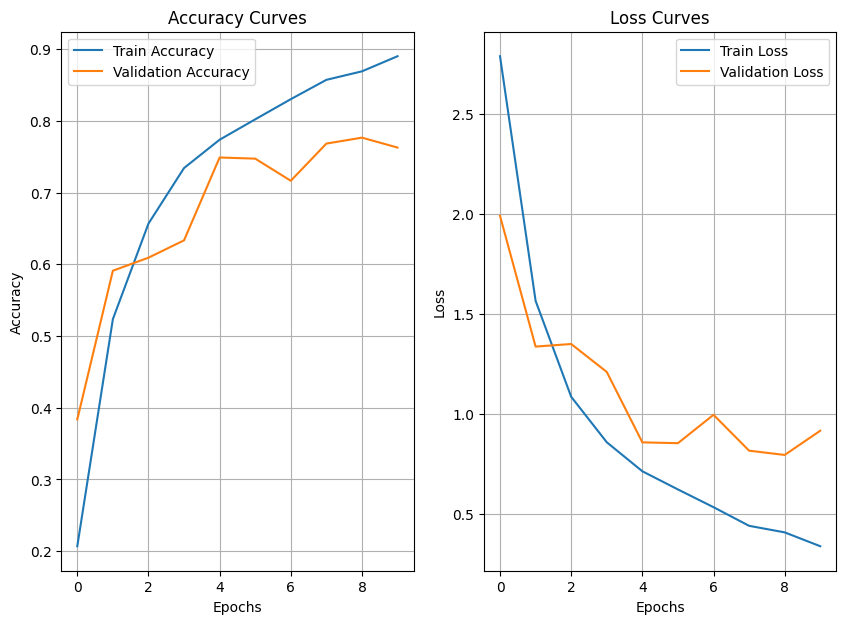

In [37]:
plot_loss_acc_curves(audio_model_results)

### Creating the Confusion Matrix

In [38]:
#1. Making predictions with our trained model on the validictory dataset
y_preds_valid = []
audio_model.eval()
with torch.inference_mode():
    for X,y in tqdm(val_loader, desc="Making predictions on validictory dataset"):
        # Move data to the target device
        X,y = X.to(device),y.to(device)

        # Turning logits into probabilities to the required labels
        y_pred_valid = torch.softmax(audio_model(X), dim=1).argmax(dim=1)  # Convert logits to probabilities to required labels

        # Append the predictions to the list
        y_preds_valid.append(y_pred_valid.cpu())

# Concatinating all predictions and turning the list into one tensor
print(y_preds_valid) 
y_preds_valid_tensor = torch.cat(y_preds_valid)

Making predictions on validictory dataset: 100%|██████████| 79/79 [00:00<00:00, 194.73it/s]

[tensor([ 3, 20, 20, 14, 26, 30, 20, 35, 11, 10, 16, 13,  5,  3, 23, 27, 18, 22,
         8,  9, 24, 34, 16, 15, 16, 29,  1,  7, 28, 16,  6, 31]), tensor([22, 12, 19, 16, 12, 30, 24, 21, 28, 22, 12,  8, 16, 24, 20, 35, 35, 18,
        34, 31, 35, 30, 24, 28, 32, 34,  9, 26, 18, 24, 34, 27]), tensor([28,  5, 20, 13,  5, 20,  8, 26, 22, 20, 16,  8, 23, 20, 21,  6, 24, 24,
        22,  5, 30, 30, 24,  8, 35, 23, 28, 24,  7, 16,  1, 27]), tensor([ 4, 34,  9, 22, 17, 16, 21,  6,  6, 29, 19, 15, 29, 34, 35, 28, 11,  5,
         7, 28,  7, 34, 20, 11, 19, 34, 12, 33, 22, 22, 12, 16]), tensor([15,  6, 27, 34, 35, 11,  8, 10, 13, 27,  6, 16,  6, 35, 35,  6, 12, 15,
        11, 12, 17, 15, 20, 20, 22, 34, 27, 34, 22, 30, 24, 17]), tensor([11, 26, 34, 22, 22, 12,  7, 29, 34, 18, 20,  3, 26,  8,  4, 22, 33, 18,
         3, 13,  3, 22, 31, 11, 22, 11, 20, 32,  9, 29, 28, 20]), tensor([16, 12, 15, 11, 11, 29,  3, 34, 19, 31, 12, 22, 23,  8, 35, 24,  9,  3,
        22, 17, 34, 15, 33,  6,  3, 28, 20,

In [39]:
# #1. Making predictions with our trained model on the validictory dataset
# random_audio_path_list = random_sample_generator(train_audio_path_list,seed=40)
# training_df = creating_df(random_audio_path_list)
# training_mfcc_df = mfcc_df_creator(training_df)
# X_train, X_val, y_train, y_val = slitting_df(training_mfcc_df)
# class_to_idx,y_train_idx,y_val_idx = indexing(class_names,y_train=y_train,y_val=y_val)
# X_train_tensor,y_train_tensor,X_val_tensor,y_val_tensor = converting_to_tensor(X_train=X_train,X_val=X_val,y_train_idx=y_train_idx,y_val_idx=y_val_idx)
# train_loader,val_loader = creating_dataloaders(X_train_tensor,y_train_tensor,X_val_tensor,y_val_tensor)
    
# audio_model = Audio_classifier(input_units=1,
#                                hidden_units=10,
#                                output_units=len(class_names)).to(device)
# audio_model.load_state_dict(torch.load(f=model_save_path))
# audio_model.to(device)

# y_preds_valid = []
# audio_model.eval()
# with torch.inference_mode():
#     for X,y in tqdm(val_loader, desc="Making predictions on validictory dataset"):
#         # Move data to the target device
#         X,y = X.to(device),y.to(device)

#         # Turning logits into probabilities to the required labels
#         y_pred_valid = torch.softmax(audio_model(X), dim=1).argmax(dim=1)  # Convert logits to probabilities to required labels

#         # Append the predictions to the list
#         y_preds_valid.append(y_pred_valid.cpu())

# # Concatinating all predictions and turning the list into one tensor
# print(y_preds_valid) 
# y_preds_valid_tensor = torch.cat(y_preds_valid)

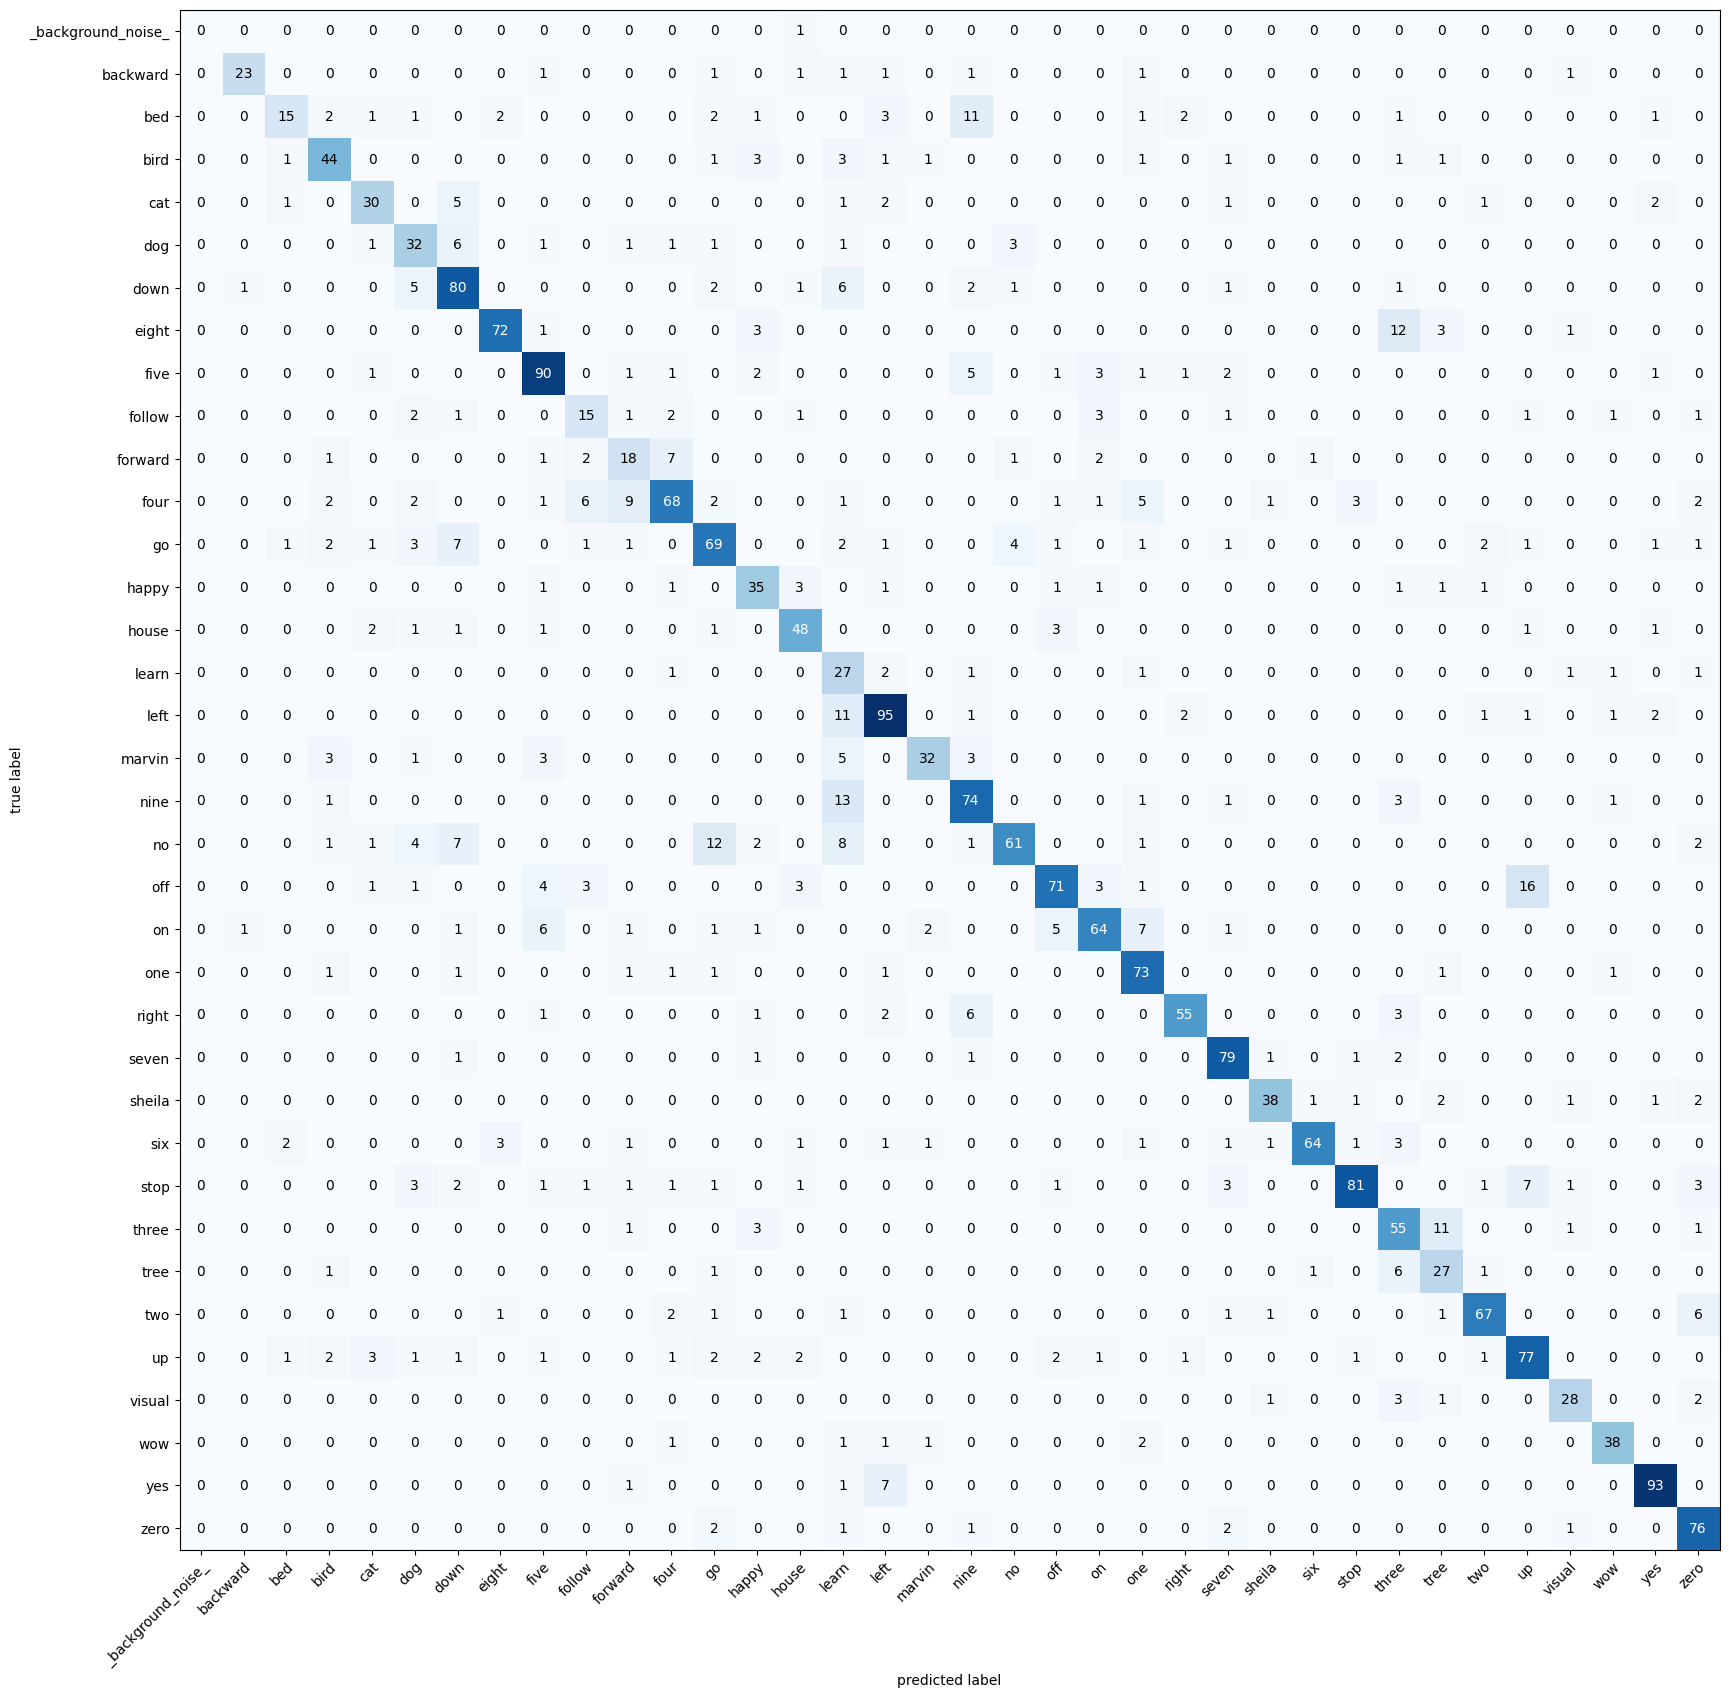

In [40]:
confusion_matrix = ConfusionMatrix(num_classes=len(class_names),
                                   task='multiclass',
                                   normalize=None).to(device)
confusion_matrix_tensor = confusion_matrix(
    preds=y_preds_valid_tensor.to(device),
    target=y_val_tensor.to(device)
)

# Plotting the Confusion Matrix
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix_tensor.cpu().numpy(),
                               class_names=class_names,
                               figsize=(20, 20),
                               cmap="Blues")

### Evaluating the model on test dataset

In [42]:
# Prepare test MFCC features as tensor
max_length = 44  # same as used for training/validation
X_test_np = np.stack([pad_or_truncate(mfcc, max_length) for mfcc in test_mfcc_df['mfcc_data']])
X_test_np = X_test_np[:, np.newaxis, :, :]  # shape: [batch, 1, n_mfcc, time]
X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32)

# If you have test labels, you can also create y_test_tensor here
# Otherwise, just use X_test_tensor for inference

test_loader = DataLoader(TensorDataset(X_test_tensor), batch_size=1, shuffle=False)

In [46]:
audio_model.eval()
with torch.inference_mode():
    X= X_test_tensor.to(device)
    y_pred = audio_model(X)
    y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
    y_pred_class_name = list(class_names[i] for i in y_pred_class)

print(y_pred_class_name)

['down', 'down', 'yes', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'dog', 'dog', 'nine', 'down', 'down', 'down', 'down', 'down', 'down', 'happy', 'dog', 'two', 'down', 'down', 'down', 'down', 'on', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'left', 'left', 'down', 'bed', 'bed', 'down', 'cat', 'down', 'down', 'down', 'down', 'down', 'down', 'dog', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'seven', 'down', 'no', 'down', 'down', 'down', 'down', 'dog', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'dog', 'nine', 'bird', 'learn', 'learn', 'nine', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'no', 'down', 'down', 'down', 'down', 'down', 'down', 'dog', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'learn', 'down', 'dow

In [55]:
for i in range(len(test_audio_path_list)):
    ipd.Audio(test_audio_path_list[i])
    print(f"Audio: {test_audio_path_list[i].name}, Predicted Class: {y_pred_class_name[i]}")
    print()

Audio: 022cd682_nohash_0.wav, Predicted Class: down

Audio: 0c40e715_nohash_0.wav, Predicted Class: down

Audio: 0c540988_nohash_0.wav, Predicted Class: yes

Audio: 0cb74144_nohash_0.wav, Predicted Class: down

Audio: 0cb74144_nohash_1.wav, Predicted Class: down

Audio: 0cb74144_nohash_2.wav, Predicted Class: down

Audio: 0cb74144_nohash_3.wav, Predicted Class: down

Audio: 0cb74144_nohash_4.wav, Predicted Class: down

Audio: 0ea0e2f4_nohash_0.wav, Predicted Class: down

Audio: 0f250098_nohash_0.wav, Predicted Class: down

Audio: 0f250098_nohash_1.wav, Predicted Class: down

Audio: 0fa1e7a9_nohash_0.wav, Predicted Class: down

Audio: 189cbabe_nohash_0.wav, Predicted Class: down

Audio: 189cbabe_nohash_1.wav, Predicted Class: down

Audio: 189cbabe_nohash_2.wav, Predicted Class: down

Audio: 189cbabe_nohash_3.wav, Predicted Class: down

Audio: 189cbabe_nohash_4.wav, Predicted Class: down

Audio: 18f8afd5_nohash_0.wav, Predicted Class: down

Audio: 18f8afd5_nohash_1.wav, Predicted Class: 